In [10]:
import torch

t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved

print('total: {:}\nreserved: {:}\nallocated: {:}\nfree: {:}'.format(t/1e9,r/1e9,a/1e9,f/1e9))

total: 4.294967296
reserved: 0.591396864
allocated: 0.320082944
free: 0.27131392


In [20]:
import pickle

para = 'Emoid'

# Load meta dict

with open('../../AllSubjectsMeta.bin', 'rb') as f:
    meta = pickle.load(f)
    
# Load rest subject ids and splits

with open('../../../BrainAgePredictWrat/' + para + 'Only10FoldSplit.bin', 'rb') as f:
    splits = pickle.load(f)
    subids = splits['cand' + para + 'YesWrat']
    groups = splits['groups']
    
print(len(subids))

620


In [21]:
import numpy as np

paradigm = 'emoid'
subidsNp = np.array(subids)

# Load timeseries

def loadSeries(prefix, para, idx):
    with open('{:}/{:}_fmri_power264/timeseries/{:}.bin'.format(prefix, para, idx), 'rb') as f:
        return pickle.load(f)

all_ts = [loadSeries('../..', paradigm, meta[subid][paradigm]) for subid in subidsNp]

print('Loading complete')

Loading complete


In [22]:
# Normalize timeseries

def normalizeSubjects(subjects):
    for i in range(len(subjects)):
        subj = subjects[i]
        subj -= np.mean(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        subj /= np.std(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        if np.sum(np.isnan(subj)) > 0:
            print('nan {:}'.format(i))
        if np.sum(np.isinf(subj)) > 0:
            print('inf {:}'.format(i))
            
normalizeSubjects(all_ts)

print('Complete')

Complete


In [26]:
# Create feature vectors (right now just ages, maleness, and femaless)

X_all = []
for subid in subidsNp:
    subj = meta[subid]
    maleness = 1 if subj['meta']['Gender'] == 'M' else 0
    femaleness = 1 if maleness == 0 else 0
    feat = np.array([subj['meta']['AgeInMonths'], maleness, femaleness])
    X_all.append(feat)
X_all = np.vstack(X_all)

print(X_all[10:20])
print('Complete')

[[223   1   0]
 [190   0   1]
 [197   0   1]
 [145   1   0]
 [148   0   1]
 [142   0   1]
 [123   1   0]
 [176   1   0]
 [129   0   1]
 [173   1   0]]
Complete


In [23]:
# Load WRAT for subjects

import numpy as np

idWratDict = {}

with open('../../wrat.csv') as f:
    for line in f.readlines()[1:]:
        parts = line.split(',')
        try:
            idWratDict[int(parts[0])] = int(parts[3])
        except Exception as e:
            print(parts[0])
            print(e)
            
wrat = np.array([idWratDict[subid] for subid in subids])

print(wrat.shape)
print('Complete')

603056110671
invalid literal for int() with base 10: 'NaN\n'
603317055381
invalid literal for int() with base 10: 'NaN\n'
604847970437
invalid literal for int() with base 10: 'NaN\n'
(620,)
Complete


In [24]:
# Calculate pearson matrices

all_p = np.stack([np.corrcoef(ts) for ts in all_ts])

print(all_p.shape)

(620, 264, 264)


In [25]:
# MLP

import torch
import torch.nn as nn

nHid = 80
nFC = 264*264
dp = nn.Dropout(p=0.05)
lu = nn.ReLU()

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(nFC, nHid).cuda()
        self.fc2 = nn.Linear(nHid, nHid).cuda()
        self.fc3 = nn.Linear(nHid, 1).cuda()
        
    def forward(self, x):
        x = lu(self.fc1(dp(x)))
        x = lu(self.fc2(x))
        return self.fc3(x)
    
# Pearson matrices
all_p_t = torch.from_numpy(all_p).reshape(-1,nFC).float()
agesPredMLP = torch.zeros(all_p_t.shape[0])

import random
    
# Loop over splits 
splitIdx = 0
for trainIdcs, testIdcs in groups:
    mlp = MLP()
    optim = torch.optim.Adam(mlp.parameters(), lr=1e-3)
    
    train_p = all_p_t[trainIdcs].cuda()
    test_p = all_p_t[testIdcs].cuda()
    
#     X_train = X_all[trainIdcs,0]
    X_train = wrat[trainIdcs]
    
    running = 0
    nEpoch = 3000
    pPeriod = 200
    nB = 10
    N = train_p.shape[0]

    for epoch in range(nEpoch):
        batch = []
        truth = torch.zeros(nB).float().cuda()
        for i in range(nB):
            idx = random.randint(0,N-1)
            batch.append(train_p[idx])
            truth[i] = X_train[idx]
        batch = torch.stack(batch)
        optim.zero_grad()
        pred = mlp(batch).flatten()
        loss = torch.sum((pred-truth)**2)
        loss.backward()
        running += loss.detach().cpu()
        optim.step()
        if epoch % pPeriod == 0 or epoch == nEpoch-1:
            if epoch != 0:
                if epoch % pPeriod != 0:
                    running /= epoch % pPeriod
                else:
                    running /= pPeriod
            print('epoch {:d} loss={:f}'.format(epoch, ((running/nB)**0.5)/12))
            running = 0

    print('Finished training')
    
    agesPredMLP[testIdcs] = mlp(test_p).flatten().detach().cpu()
    
    print('Completed split {:}'.format(splitIdx))
    splitIdx += 1

print('All complete')

epoch 0 loss=8.359637
epoch 200 loss=2.185267
epoch 400 loss=1.159946
epoch 600 loss=0.952852
epoch 800 loss=0.784187
epoch 1000 loss=0.551706
epoch 1200 loss=0.486050
epoch 1400 loss=0.417814
epoch 1600 loss=0.328302
epoch 1800 loss=0.283866
epoch 2000 loss=0.249520
epoch 2200 loss=0.228002
epoch 2400 loss=0.231709
epoch 2600 loss=0.243741
epoch 2800 loss=0.309510
epoch 2999 loss=0.194595
Finished training
Completed split 0
epoch 0 loss=8.161456
epoch 200 loss=2.179763
epoch 400 loss=1.136768
epoch 600 loss=0.969701
epoch 800 loss=0.761618
epoch 1000 loss=0.601706
epoch 1200 loss=0.449845
epoch 1400 loss=0.490887
epoch 1600 loss=0.301811
epoch 1800 loss=0.228364
epoch 2000 loss=0.224052
epoch 2200 loss=0.305220
epoch 2400 loss=0.281881
epoch 2600 loss=0.184123
epoch 2800 loss=0.202061
epoch 2999 loss=0.172663
Finished training
Completed split 1
epoch 0 loss=9.310350
epoch 200 loss=1.992476
epoch 400 loss=1.150106
epoch 600 loss=0.921305
epoch 800 loss=0.754896
epoch 1000 loss=0.572387

[[1.         0.33549605]
 [0.33549605 1.        ]]
16.143642560301693
12.33444071123677


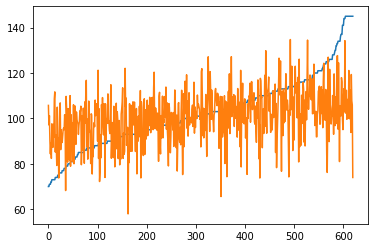

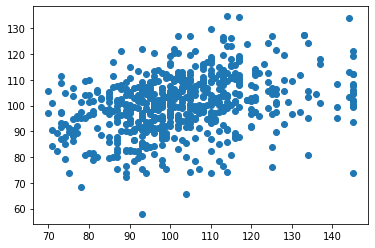

In [26]:
import matplotlib.pyplot as plt

# test_labels = X_all[:,0]
test_labels = wrat
predY = agesPredMLP.detach().cpu().numpy()

idcs = np.argsort(test_labels[:])
yPred = predY[idcs]
y = test_labels[idcs]

corr = np.corrcoef(y, yPred)
rmse = (np.sum((y-yPred)**2)/len(y))**0.5
mae = np.sum(np.abs(y-yPred))/len(y)
# rmse = (np.sum((y-yPred)**2)/len(y))**0.5/12
# mae = np.sum(np.abs(y-yPred))/12/len(y)

print(corr)
print(rmse)
print(mae)

plt.plot(y, label='Truth')
plt.plot(yPred, label='Prediction')
plt.show()

plt.scatter(y, yPred)
plt.show()

In [27]:
# Save predictions

with open('../../../BrainAgePredictWrat/Wrat/MLPWratEmoidPredictions.bin', 'wb') as f:
    pickle.dump(agesPredMLP.detach().cpu().numpy(), f)
    
print('Complete')

Complete


In [28]:
# Check predictions

with open('../../../BrainAgePredictWrat/Wrat/MLPWratEmoidPredictions.bin', 'rb') as f:
    check = pickle.load(f)
    
print(check[0:10])
print(agesPredMLP[0:10])
print(np.count_nonzero(check == agesPredMLP.detach().cpu().numpy()))
print(check.shape[0])

[ 98.94485  102.355     91.70432   57.938103 100.38806  110.28434
 103.49369   96.818886 107.02888  109.2333  ]
tensor([ 98.9448, 102.3550,  91.7043,  57.9381, 100.3881, 110.2843, 103.4937,
         96.8189, 107.0289, 109.2333])
620
620
